<a href="https://colab.research.google.com/github/belindalafaille/Time-Series-Forecasting-With-Python-Using-Facebook-Prophet-SARIMAX-LSTM.../blob/main/Facebook_Prophet_Parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Directory, Library, Data

In [1]:
%cd /content/drive/MyDrive/Zero to Mastery Academy/Time Series Forecasting Product

/content/drive/MyDrive/Zero to Mastery Academy/Time Series Forecasting Product


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [3]:
# Loading the data
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


# Data Preparation

In [4]:
# Rename variable
df= df.rename(columns= {'Demand': 'y',
                        'Date': 'ds'})
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [5]:
# Date variable
df.ds= pd.to_datetime(df.ds,
               format= '%m/%d/%Y')
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2187   2020-12-27
2188   2020-12-28
2189   2020-12-29
2190   2020-12-30
2191   2020-12-31
Name: ds, Length: 2192, dtype: datetime64[ns]

# Model Input Preparation



## Holidays

In [6]:
# Easter Holidays
easter_dates= pd.to_datetime(df[df.Easter == 1].ds)
easter_dates

94     2015-04-05
451    2016-03-27
836    2017-04-16
1186   2018-04-01
1571   2019-04-21
1928   2020-04-12
Name: ds, dtype: datetime64[ns]

In [7]:
easter= pd.DataFrame({'holiday': 'easter',
                      'ds': easter_dates,
                      'lower_window': -5,
                      'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [8]:
# Thanksgiving Holidays
thanksgiving_dates= pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving_dates

329    2015-11-26
693    2016-11-24
1057   2017-11-23
1421   2018-11-22
1792   2019-11-28
2156   2020-11-26
Name: ds, dtype: datetime64[ns]

In [9]:
thanksgiving= pd.DataFrame({'holiday': 'thanksgiving',
                      'ds': thanksgiving_dates,
                      'lower_window': -3,
                      'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


Christmas is included as a regressor.

## Combining the Holidays

In [10]:
# combine the holidays
holidays= pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


Now that we have a dataframe with easter and thanksgiving dates, they can be removed from the main df to avoid double input in our model.

In [11]:
# Remove holidays columns from df
df= df.drop(columns= ['Easter', 'Thanksgiving'])
df.head(1)

,ds,y,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,3.68,41.305


# Facebook Prophet Model

In [12]:
# FB model
m= Prophet(holidays= holidays,
           seasonality_mode= 'multiplicative',
           seasonality_prior_scale= 10, # default value
           holidays_prior_scale= 10,
           changepoint_prior_scale= 0.05
           )

# Add Regressors
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')

# Fitting the model
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/77i20i53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/c9vv72tn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45210', 'data', 'file=/tmp/tmp6b51la4p/77i20i53.json', 'init=/tmp/tmp6b51la4p/c9vv72tn.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model4s6whzqe/prophet_model-20230615223916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


These 4 parameters: seasonality_mode, seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale, will be tuned (parameter tuning section) to achieve maximum model accuracy/performance.

This model has 3 regressors: Christmas, Temperature, Marketing.

# Cross-Validation

Two types:
* Rolling Forecast: Adds training data as it performs Cross-Validation
* Sliding Forecast: Always keeps the same size for the training data

In [13]:
# Check total observations
df.shape[0] -180

2012

In [14]:
# cross-validation
df_cv= cross_validation(m,
                        horizon= '31 days', # size of test set: 1 month
                        period= '16 days', # every couple week, new forecast created
                        initial= '2012 days',
                        parallel = 'processes')

INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e776950>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6e44hvo2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/c9mej5es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/p24evnac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57860', 'data', 'file=/tmp/tmp6b51la4p/6e44hvo2.json', 'init=/tmp/tmp6b51la4p/p24evnac.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelcwf5wf24/prophet_model-20230615223917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/h1o3_45o.json
DE

In [15]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.801474,541.264734,672.772176,571.069531,2020-07-09
1,2020-07-11,722.734395,655.757232,791.132485,677.106981,2020-07-09
2,2020-07-12,637.595488,568.967502,701.270984,619.572774,2020-07-09
3,2020-07-13,769.922480,707.719221,836.348927,808.932621,2020-07-09
4,2020-07-14,637.229498,572.298283,704.702807,661.791644,2020-07-09


# Model Performance

In [16]:
# Performance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2851.098789,53.395681,43.470653,0.059104,0.060362,0.060251,0.767742
1,5 days,2836.677028,53.260464,44.567996,0.062290,0.064404,0.063157,0.735484
2,6 days,3557.733802,59.646742,50.666561,0.070010,0.064404,0.071500,0.700000
3,7 days,2851.628458,53.400641,43.245387,0.060954,0.059650,0.062075,0.703226
4,8 days,2799.686506,52.912064,40.808150,0.056397,0.057064,0.057947,0.732258


In [17]:
performance_metrics(df_cv)['rmse'].mean()

53.892280761599565

In [18]:
# RMSE and MAPE
print('RMSE: ', round(performance_metrics(df_cv)['rmse'].mean(),1))
print('MAPE: ', 100 * round(performance_metrics(df_cv)['mape'].mean(),3), '%')

RMSE:  53.9
MAPE:  5.800000000000001 %


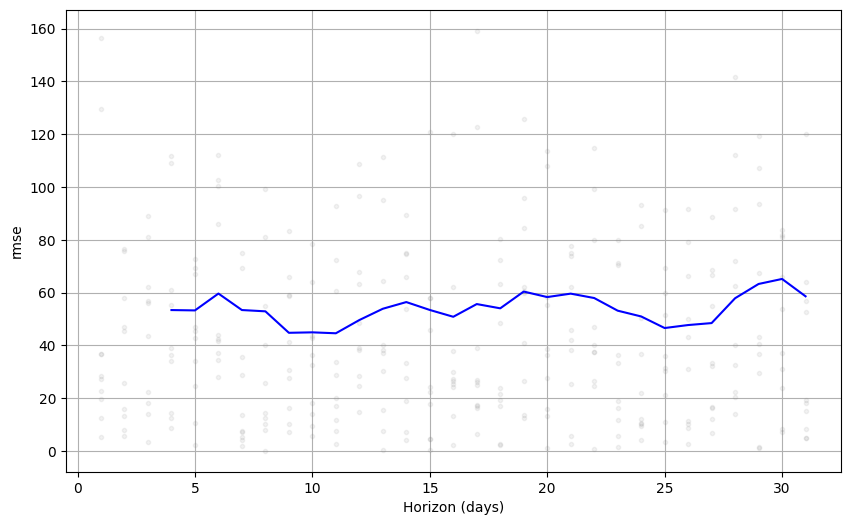

In [19]:
# Plotting
plot_cross_validation_metric(df_cv, metric= 'rmse');

The forecast is reliable as time goes by as the error ranges between ~45 and ~65.

# Parameter Tuning

In [20]:
# Parameter Tuning
param_grid= {'seasonality_mode': ['additive', 'multiplicative'],
             'seasonality_prior_scale': [1, 5, 10, 20],
             'holidays_prior_scale': [5, 10, 20, 25],
             'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid= ParameterGrid(param_grid)
len(list(grid))

128

In [21]:
# Store the results
rmse= []

# Loop
i= 1
for params in grid:
  print(f'{i}/ {len(list(grid))}')
  # build the model
  m= Prophet(holidays= holidays,
           seasonality_mode= params['seasonality_mode'],
           seasonality_prior_scale= params['seasonality_prior_scale'],
           holidays_prior_scale= params['holidays_prior_scale'],
           changepoint_prior_scale= params['changepoint_prior_scale']
           )

  # Add Regressors
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.add_regressor('Marketing')

  # Fitting the model
  m.fit(df)

  # cross validation
  df_cv= cross_validation(m,
                        horizon= '31 days',
                        period= '16 days',
                        initial= '2012 days',
                        parallel = 'processes')

  # measure error and store the results
  error = performance_metrics(df_cv)['rmse'].mean()
  rmse.append(error)

  i+=1


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vvoln4n6.json


1/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zy281ic9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5911', 'data', 'file=/tmp/tmp6b51la4p/vvoln4n6.json', 'init=/tmp/tmp6b51la4p/zy281ic9.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelhf5lsoy3/prophet_model-20230615223930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb7cce3c310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vyyiile7.json
DEBUG:cmdstanpy:input tempfile: 

2/ 128


22:39:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded7040>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qhbon01y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/jrspssvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8ou7rs_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26025', 'data', 'file=/tmp/tmp6b51la4p/jrspssvx.json', 'init=/tmp/tmp6b51la4p/8ou7rs_6.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelaxjomcrd/prophet_model-20230615223937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

3/ 128


22:39:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e370220>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_yuifoez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/013kh456.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/4myecw2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/c1wsqt4i.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79586', 'data', 'file=/tmp/tmp6b51la4p/_yuifoez.json', 'init=/tmp/tmp6b51la4p/4myecw2x.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelyab1t4q4/prophet_model-20230615223942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:3

4/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ctm7mkab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70385', 'data', 'file=/tmp/tmp6b51la4p/mx03b82f.json', 'init=/tmp/tmp6b51la4p/ctm7mkab.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model25rlljyt/prophet_model-20230615223947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb7cce3c310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/dywno6si.json
DEBUG:cmdstanpy:input tempfile:

5/ 128


22:39:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded4100>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/z8b8k_gm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qfsalbg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vr1b4wrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98400', 'data', 'file=/tmp/tmp6b51la4p/qfsalbg1.json', 'init=/tmp/tmp6b51la4p/vr1b4wrn.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model_vao35_e/prophet_model-20230615223952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

6/ 128


22:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e370220>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wigb3aaj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/y0um8e9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ff0th8n_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99423', 'data', 'file=/tmp/tmp6b51la4p/wigb3aaj.json', 'init=/tmp/tmp6b51la4p/ff0th8n_.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelzwdsgc1i/prophet_model-20230615223957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

7/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/t0ukmnw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67683', 'data', 'file=/tmp/tmp6b51la4p/zwqdv8vh.json', 'init=/tmp/tmp6b51la4p/t0ukmnw8.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeleun8k61n/prophet_model-20230615224006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb7cce3c310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_q4zn322.json
DEBUG:cmdstanpy:input tempfile:

8/ 128


22:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb7cce3c310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0d5ptx5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/udvv84bu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/mrkre80e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87621', 'data', 'file=/tmp/tmp6b51la4p/0d5ptx5y.json', 'init=/tmp/tmp6b51la4p/mrkre80e.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model4xanljxj/prophet_model-20230615224013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

9/ 128


22:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e373bb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/27fhyy9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/v7ehhv8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lvkfy2tv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xi6jfr1u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80909', 'data', 'file=/tmp/tmp6b51la4p/v7ehhv8j.json', 'init=/tmp/tmp6b51la4p/lvkfy2tv.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelmf_jd9yb/prophet_model-20230615224018.csv', 'method=optimize', 'algorithm=lbfg

10/ 128


22:40:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded75b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ktd7zwpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/itur630c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/m03giheu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/e0xsabhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9848', 'data', 'file=/tmp/tmp6b51la4p/itur630c.json', 'init=/tmp/tmp6b51la4p/e0xsabhm.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model2yq7a_1p/prophet_model-20230615224023.csv', 'method=optimize', 'algorithm=lbfgs

11/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/y2ki8b4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64159', 'data', 'file=/tmp/tmp6b51la4p/q5rq4j77.json', 'init=/tmp/tmp6b51la4p/y2ki8b4o.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model587a6cqg/prophet_model-20230615224028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e373bb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/x701k3_j.json
DEBUG:cmdstanpy:input tempfile:

12/ 128


22:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3739d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xddor6tk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/889tokyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ep3daqfh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/elyt3y6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20153', 'data', 'file=/tmp/tmp6b51la4p/xddor6tk.json', 'init=/tmp/tmp6b51la4p/ep3daqfh.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelx_oxog4a/prophet_model-20230615224033.csv', 'method=optimize', 'algorithm=lbfg

13/ 128


22:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded67d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/f3hj1_zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/i53o_xtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_lhkz21d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28633', 'data', 'file=/tmp/tmp6b51la4p/f3hj1_zl.json', 'init=/tmp/tmp6b51la4p/_lhkz21d.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model7xmuzoma/prophet_model-20230615224039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6h7cs9y9.json
DEBU

14/ 128


22:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e373e20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/fvedw3w8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/w1qkniig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tbmdm6qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32621', 'data', 'file=/tmp/tmp6b51la4p/w1qkniig.json', 'init=/tmp/tmp6b51la4p/tbmdm6qf.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelplmt3k4z/prophet_model-20230615224045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

15/ 128


22:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded71c0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/4j7qso0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/cfjy_ka2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/q306s7d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/92iwchkx.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58410', 'data', 'file=/tmp/tmp6b51la4p/cfjy_ka2.json', 'init=/tmp/tmp6b51la4p/q306s7d7.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelqkrzy3j8/prophet_model-20230615224049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

16/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/v53ajugq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88487', 'data', 'file=/tmp/tmp6b51la4p/w655dt3x.json', 'init=/tmp/tmp6b51la4p/v53ajugq.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelvkm2fnf3/prophet_model-20230615224054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:40:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e34d0f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/pt9o412z.json
DEBUG:cmdstanpy:input tempfile:

17/ 128


22:40:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df186d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wybcnljb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/o7w0lil3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/cyly62et.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76191', 'data', 'file=/tmp/tmp6b51la4p/o7w0lil3.json', 'init=/tmp/tmp6b51la4p/cyly62et.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelkyqf78bk/prophet_model-20230615224100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:00 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

18/ 128


22:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e7a1e10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ju8zmnn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0c7hvp1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/rrw_xhbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/q5ft85ii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52330', 'data', 'file=/tmp/tmp6b51la4p/0c7hvp1x.json', 'init=/tmp/tmp6b51la4p/q5ft85ii.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelpfafphrv/prophet_model-2023

19/ 128


22:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81ffa0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8gxe4ops.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lp374cp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hi3uv3yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/sul14fwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28586', 'data', 'file=/tmp/tmp6b51la4p/lp374cp9.json', 'init=/tmp/tmp6b51la4p/sul14fwm.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelqbkcy1f8/prophet_model-20230615224112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

20/ 128


22:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81fd30>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/eatggina.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/df59us17.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7gedm5ut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69577', 'data', 'file=/tmp/tmp6b51la4p/eatggina.json', 'init=/tmp/tmp6b51la4p/7gedm5ut.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelngcqzc2j/prophet_model-20230615224116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

21/ 128


22:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e7a3040>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/emfgh9p2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7ioudwb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wxgocr9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ruw_lyw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51131', 'data', 'file=/tmp/tmp6b51la4p/emfgh9p2.json', 'init=/tmp/tmp6b51la4p/wxgocr9g.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model5mcafh9s/prophet_model-2023

22/ 128


22:41:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3739d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/obgqr3p8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/eribvjjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ky__alp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/4lwz09ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17913', 'data', 'file=/tmp/tmp6b51la4p/obgqr3p8.json', 'init=/tmp/tmp6b51la4p/ky__alp3.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelcm2jun4i/prophet_model-2023

23/ 128


22:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df199c0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/x_fu17ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lw68riw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0aw9e7k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7zjh4lr7.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91609', 'data', 'file=/tmp/tmp6b51la4p/lw68riw6.json', 'init=/tmp/tmp6b51la4p/0aw9e7k7.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelyr685t6a/prophet_model-20230615224131.csv', 'method=optimize', 'algorithm=lbfg

24/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/dbvk3it_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76919', 'data', 'file=/tmp/tmp6b51la4p/n4eww0qk.json', 'init=/tmp/tmp6b51la4p/dbvk3it_.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model48odhbff/prophet_model-20230615224136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded57b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/63rh06me.json
DEBUG:cmdstanpy:input tempfile:

25/ 128


22:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e373e20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xoxbjnjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/d8bjqyqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1tj399fx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7lqsh8mg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80931', 'data', 'file=/tmp/tmp6b51la4p/d8bjqyqh.json', 'init=/tmp/tmp6b51la4p/7lqsh8mg.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model8rcibqyg/prophet_model-2023

26/ 128


22:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3cd570>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/m_unhodj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/q49u35qz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/trbkc0ew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9850', 'data', 'file=/tmp/tmp6b51la4p/q49u35qz.json', 'init=/tmp/tmp6b51la4p/trbkc0ew.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelovlqm6ei/prophet_model-20230615224148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tov8sc8r.json
22:41

27/ 128


22:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df1b2e0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nhx4x8hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vpuw8jw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_gs_q7m2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/x27yxj_k.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5815', 'data', 'file=/tmp/tmp6b51la4p/nhx4x8hk.json', 'init=/tmp/tmp6b51la4p/x27yxj_k.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelllleh8r9/prophet_model-20230

28/ 128


22:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81e5f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/rg6z32lh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/34x_5am7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tw0uf8dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84660', 'data', 'file=/tmp/tmp6b51la4p/rg6z32lh.json', 'init=/tmp/tmp6b51la4p/tw0uf8dc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeln67lh38y/prophet_model-20230615224200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

29/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zish_7t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63867', 'data', 'file=/tmp/tmp6b51la4p/udabsn9g.json', 'init=/tmp/tmp6b51la4p/zish_7t8.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelap02mmq6/prophet_model-20230615224205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e7a2830>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8m_ckame.json
DEBUG:cmdstanpy:input tempfile:

30/ 128


22:42:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df27940>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9qvuipft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/rvghjsco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/jzg2wvlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_riq747c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19181', 'data', 'file=/tmp/tmp6b51la4p/rvghjsco.json', 'init=/tmp/tmp6b51la4p/jzg2wvlo.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelmap_cnlh/prophet_model-2023

31/ 128


22:42:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df27f10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/895haz3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1_5dzzf0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/akr6qg1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31534', 'data', 'file=/tmp/tmp6b51la4p/1_5dzzf0.json', 'init=/tmp/tmp6b51la4p/akr6qg1b.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeljx2s_21k/prophet_model-20230615224215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:15 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

32/ 128


22:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40dea0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_x_1le_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5h2ug1ye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/y73fhe1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/yhfjbnt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64320', 'data', 'file=/tmp/tmp6b51la4p/_x_1le_x.json', 'init=/tmp/tmp6b51la4p/y73fhe1j.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model74vmrzfe/prophet_model-20230615224222.csv', 'method=optimize', 'algorithm=lbfg

33/ 128


22:42:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df26e90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/aqp8bp7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xegp5s20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ia2ry7jf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9d0sbw0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1058', 'data', 'file=/tmp/tmp6b51la4p/aqp8bp7o.json', 'init=/tmp/tmp6b51la4p/9d0sbw0x.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modela6l07960/prophet_model-20230

34/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7i8c7oxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14351', 'data', 'file=/tmp/tmp6b51la4p/fphai8h7.json', 'init=/tmp/tmp6b51la4p/7i8c7oxs.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model_yg0in9d/prophet_model-20230615224231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3cd240>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/454juqdm.json
DEBUG:cmdstanpy:input tempfile:

35/ 128


22:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81dff0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/a2ncrs69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ih54q8de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/j6qt6e6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35500', 'data', 'file=/tmp/tmp6b51la4p/a2ncrs69.json', 'init=/tmp/tmp6b51la4p/j6qt6e6x.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelk349c8wa/prophet_model-20230615224237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

36/ 128


22:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3cd240>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6srq9c9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/il84wcck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bvzcn00d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99135', 'data', 'file=/tmp/tmp6b51la4p/6srq9c9u.json', 'init=/tmp/tmp6b51la4p/bvzcn00d.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model7c2pbvqv/prophet_model-20230615224242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

37/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/iqghdsjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99648', 'data', 'file=/tmp/tmp6b51la4p/pm09ecq7.json', 'init=/tmp/tmp6b51la4p/iqghdsjn.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelr3k5dae4/prophet_model-20230615224247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb7b7141450>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/695a1x81.json
DEBUG:cmdstanpy:input tempfile:

38/ 128


22:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81d8d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/mrxa00xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1qa63htl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_kzv9wmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23487', 'data', 'file=/tmp/tmp6b51la4p/mrxa00xy.json', 'init=/tmp/tmp6b51la4p/_kzv9wmm.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modela33s_btd/prophet_model-20230615224252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:52 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

39/ 128


22:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e1780>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zx3tb5uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xv5w63pi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9yt3gau6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18766', 'data', 'file=/tmp/tmp6b51la4p/zx3tb5uv.json', 'init=/tmp/tmp6b51la4p/9yt3gau6.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model2qyc942g/prophet_model-20230615224258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

40/ 128


22:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81f6a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_ubcsz8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xpjpdef0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/je31go2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11325', 'data', 'file=/tmp/tmp6b51la4p/_ubcsz8s.json', 'init=/tmp/tmp6b51la4p/je31go2e.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelfgg14rni/prophet_model-20230615224304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

41/ 128


22:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40f790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ytxik9rq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/elm__xkn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6xhisy_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/x1hujn89.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45850', 'data', 'file=/tmp/tmp6b51la4p/elm__xkn.json', 'init=/tmp/tmp6b51la4p/6xhisy_4.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model1te5wpw2/prophet_model-20230615224309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

42/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/95v318ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48165', 'data', 'file=/tmp/tmp6b51la4p/kwh32vgt.json', 'init=/tmp/tmp6b51la4p/95v318ns.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelorjl923g/prophet_model-20230615224313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40e1a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ws81nksx.json
DEBUG:cmdstanpy:input tempfile:

43/ 128


22:43:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40d660>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/pyt6k326.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nklekcey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wg5rao3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5zyzu7_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13928', 'data', 'file=/tmp/tmp6b51la4p/nklekcey.json', 'init=/tmp/tmp6b51la4p/5zyzu7_g.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelq2pqnm9m/prophet_model-2023

44/ 128


22:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81d720>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ww7tghkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/24rbwef_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/60seitov.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/4w60dcs7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75615', 'data', 'file=/tmp/tmp6b51la4p/ww7tghkw.json', 'init=/tmp/tmp6b51la4p/60seitov.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modellqbl4_79/prophet_model-20230615224324.csv', 'method=optimize', 'algorithm=lbfg

45/ 128


22:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df24220>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xihq6wz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3c2otehm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/sl9qtep2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97248', 'data', 'file=/tmp/tmp6b51la4p/xihq6wz1.json', 'init=/tmp/tmp6b51la4p/sl9qtep2.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelwz0qfzdv/prophet_model-20230615224330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

46/ 128


22:43:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77ded6fb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/itlk1_dd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/avz9bj9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bruyqfou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41997', 'data', 'file=/tmp/tmp6b51la4p/avz9bj9o.json', 'init=/tmp/tmp6b51la4p/bruyqfou.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modely7xd_pfg/prophet_model-20230615224335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

47/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vx6xkv1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9003', 'data', 'file=/tmp/tmp6b51la4p/8t1ttmxk.json', 'init=/tmp/tmp6b51la4p/vx6xkv1k.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelx1snqnu7/prophet_model-20230615224340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e8490>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ivy45ke3.json
DEBUG:cmdstanpy:input tempfile: 

48/ 128


22:43:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e2a10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ecggr3d5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ts8ejqff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ns450iq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7wpa4uwr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11642', 'data', 'file=/tmp/tmp6b51la4p/ecggr3d5.json', 'init=/tmp/tmp6b51la4p/ns450iq1.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model9lt4ieut/prophet_model-20230615224346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:4

49/ 128


22:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df18e50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_rsqht95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/cwzmvdmt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ukryk60l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87874', 'data', 'file=/tmp/tmp6b51la4p/_rsqht95.json', 'init=/tmp/tmp6b51la4p/ukryk60l.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model0pjjx_xj/prophet_model-20230615224351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

50/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qgordovs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57270', 'data', 'file=/tmp/tmp6b51la4p/vobhoy26.json', 'init=/tmp/tmp6b51la4p/qgordovs.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelgctchr8g/prophet_model-20230615224356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:43:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e3010>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tum5jdst.json
DEBUG:cmdstanpy:input tempfile:

51/ 128


22:44:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81dff0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/jt1pibg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/covay6qf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_ulkc5yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wqh3a3jw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9002', 'data', 'file=/tmp/tmp6b51la4p/jt1pibg2.json', 'init=/tmp/tmp6b51la4p/_ulkc5yw.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelwleev0dc/prophet_model-20230

52/ 128


22:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e4004f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tu3iaffj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tu39icvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1itscax2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/a5hob5hv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75287', 'data', 'file=/tmp/tmp6b51la4p/tu39icvm.json', 'init=/tmp/tmp6b51la4p/1itscax2.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelhiyv9ks1/prophet_model-20230615224407.csv', 'method=optimize', 'algorithm=lbfg

53/ 128


22:44:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e0b20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/c9v1esvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/s826nh0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xnscs1wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12214', 'data', 'file=/tmp/tmp6b51la4p/c9v1esvv.json', 'init=/tmp/tmp6b51la4p/xnscs1wc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelkwlkwei7/prophet_model-20230615224413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:13 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

54/ 128


22:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81d720>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/apx33r6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xk5vxqc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qk8voe8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5ri621z9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18624', 'data', 'file=/tmp/tmp6b51la4p/xk5vxqc7.json', 'init=/tmp/tmp6b51la4p/qk8voe8_.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model99rbb1rj/prophet_model-20230615224418.csv', 'method=optimize', 'algorithm=lbfg

55/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/w4azu5jg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20357', 'data', 'file=/tmp/tmp6b51la4p/cukm2350.json', 'init=/tmp/tmp6b51la4p/w4azu5jg.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelt82vzb1b/prophet_model-20230615224423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3cd780>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ja99eika.json
DEBUG:cmdstanpy:input tempfile:

56/ 128


22:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e403520>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/tdoma9w3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1htbod70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/j6cji_9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87690', 'data', 'file=/tmp/tmp6b51la4p/1htbod70.json', 'init=/tmp/tmp6b51la4p/j6cji_9o.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeloy7qhnxb/prophet_model-20230615224429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bqcu72iz.json
DEBU

57/ 128


22:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e97e0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/t58kzjn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3qdlgk5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/2pbune7q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hjc6t9_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9203', 'data', 'file=/tmp/tmp6b51la4p/3qdlgk5m.json', 'init=/tmp/tmp6b51la4p/2pbune7q.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelnr7zg94d/prophet_model-20230615224436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
INFO:

58/ 128


22:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e400ca0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0ewhzwa9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vc28y1yj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6k5phbw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lqawwy1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33947', 'data', 'file=/tmp/tmp6b51la4p/vc28y1yj.json', 'init=/tmp/tmp6b51la4p/lqawwy1f.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modell6d0cut4/prophet_model-2023

59/ 128


22:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40e5f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3nj7twp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/sallb4uf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wki5hwrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1alv0uy8.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81742', 'data', 'file=/tmp/tmp6b51la4p/3nj7twp3.json', 'init=/tmp/tmp6b51la4p/wki5hwrg.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelycqarggz/prophet_model-20230615224446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

60/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qzb8c55n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97534', 'data', 'file=/tmp/tmp6b51la4p/9phxfdbe.json', 'init=/tmp/tmp6b51la4p/qzb8c55n.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelu17j2hr1/prophet_model-20230615224451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40dab0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/s8cy0lt9.json
DEBUG:cmdstanpy:input tempfile:

61/ 128


22:44:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e402260>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/aual6byx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ox70h5vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/umxp222s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/x2yxr395.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52137', 'data', 'file=/tmp/tmp6b51la4p/ox70h5vl.json', 'init=/tmp/tmp6b51la4p/x2yxr395.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelrvwsrl3w/prophet_model-20230615224457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

62/ 128


22:45:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40f9d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/96h63ue1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bi7xtio_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/afusg2u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6370', 'data', 'file=/tmp/tmp6b51la4p/96h63ue1.json', 'init=/tmp/tmp6b51la4p/afusg2u9.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelk1uj0u6m/prophet_model-20230615224502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdsta

63/ 128


22:45:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e81e260>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/sj88yb7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/gxifc_du.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5bk5c3c0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/2zhfi69_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18461', 'data', 'file=/tmp/tmp6b51la4p/gxifc_du.json', 'init=/tmp/tmp6b51la4p/2zhfi69_.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model4zr1oc85/prophet_model-20230615224509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:4

64/ 128


22:45:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e4f84f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/stjhzwky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hyelno1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/uockkewg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92498', 'data', 'file=/tmp/tmp6b51la4p/stjhzwky.json', 'init=/tmp/tmp6b51la4p/uockkewg.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelecq_dg5r/prophet_model-20230615224514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

65/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/4u9fxr7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50007', 'data', 'file=/tmp/tmp6b51la4p/0n4gp2nt.json', 'init=/tmp/tmp6b51la4p/4u9fxr7x.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelu35sl9gk/prophet_model-20230615224519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3ccd00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/c6cd5h_s.json
DEBUG:cmdstanpy:input tempfile:

66/ 128


22:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e0a30>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/d0ajyzij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/cuxjxvqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/d2c3qrog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99697', 'data', 'file=/tmp/tmp6b51la4p/d0ajyzij.json', 'init=/tmp/tmp6b51la4p/d2c3qrog.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelbyn_5b0_/prophet_model-20230615224528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

67/ 128


22:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e3e50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/q4zp04l8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ksk6uz64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ixnx23pj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_6nerpnn.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46692', 'data', 'file=/tmp/tmp6b51la4p/q4zp04l8.json', 'init=/tmp/tmp6b51la4p/ixnx23pj.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model17hxvja_/prophet_model-20230615224536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:4

68/ 128


22:45:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e403520>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/074991jp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lw5p0dgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/27hkfi03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37868', 'data', 'file=/tmp/tmp6b51la4p/lw5p0dgf.json', 'init=/tmp/tmp6b51la4p/27hkfi03.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model0j7ez1sj/prophet_model-20230615224543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

69/ 128


22:45:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3f7dc0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3yow0mdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_1grxc_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/leii352y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/dlf72mys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55929', 'data', 'file=/tmp/tmp6b51la4p/3yow0mdf.json', 'init=/tmp/tmp6b51la4p/leii352y.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeltis_bdm4/prophet_model-2023

70/ 128


22:45:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e4020e0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6qffk2sa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8a2ktnet.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ie6vcqu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3ac0vpj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97828', 'data', 'file=/tmp/tmp6b51la4p/6qffk2sa.json', 'init=/tmp/tmp6b51la4p/ie6vcqu9.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model5knay733/prophet_model-2023

71/ 128


22:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e91b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vty751ic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/awafyj3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/o4gvynsl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22371', 'data', 'file=/tmp/tmp6b51la4p/vty751ic.json', 'init=/tmp/tmp6b51la4p/o4gvynsl.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelsscv98yn/prophet_model-20230615224606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

72/ 128


22:46:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e4fb430>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3kgklh0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/yys2l93p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nbl2r9zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/d4zbm321.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52271', 'data', 'file=/tmp/tmp6b51la4p/3kgklh0x.json', 'init=/tmp/tmp6b51la4p/nbl2r9zk.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelujodofqp/prophet_model-20230615224613.csv', 'method=optimize', 'algorithm=lbfg

73/ 128


22:46:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e3e50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nxralj9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6zpnt8kw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/n6yqq2nk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/yx6jbw2a.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99153', 'data', 'file=/tmp/tmp6b51la4p/6zpnt8kw.json', 'init=/tmp/tmp6b51la4p/n6yqq2nk.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model_i15zexq/prophet_model-2023

74/ 128


22:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df8b850>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8j8bzs4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qoteogui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/elmctnyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/kq3jpa5c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41318', 'data', 'file=/tmp/tmp6b51la4p/8j8bzs4a.json', 'init=/tmp/tmp6b51la4p/elmctnyc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelfmshw1b_/prophet_model-20230615224629.csv', 'method=optimize', 'algorithm=lbfg

75/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/r281b08m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88566', 'data', 'file=/tmp/tmp6b51la4p/p559h052.json', 'init=/tmp/tmp6b51la4p/r281b08m.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelp140nr2b/prophet_model-20230615224636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e402680>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0gtbh_pn.json
DEBUG:cmdstanpy:input tempfile:

76/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/znolb14d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85760', 'data', 'file=/tmp/tmp6b51la4p/6gh422u3.json', 'init=/tmp/tmp6b51la4p/znolb14d.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelzgivmu8n/prophet_model-20230615224644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df8ad10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/y2762pvv.json
DEBUG:cmdstanpy:input tempfile:

77/ 128


22:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f6800>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/b32b06uw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/jxx7t4a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bm3ux9vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79226', 'data', 'file=/tmp/tmp6b51la4p/b32b06uw.json', 'init=/tmp/tmp6b51la4p/bm3ux9vf.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelz2tdkkob/prophet_model-20230615224652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:46:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

78/ 128


22:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e4fb310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5v2uqit6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/enyd_b6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8l3f_7uf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41252', 'data', 'file=/tmp/tmp6b51la4p/enyd_b6i.json', 'init=/tmp/tmp6b51la4p/8l3f_7uf.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model0y368jci/prophet_model-20230615224700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ibl_8aw7.json
22:4

79/ 128


22:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3e3370>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ee1dq7ho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xamxd9xz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6up_hwhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29102', 'data', 'file=/tmp/tmp6b51la4p/xamxd9xz.json', 'init=/tmp/tmp6b51la4p/6up_hwhp.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeluk8do1m2/prophet_model-20230615224707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:07 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

80/ 128


22:47:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e4fb310>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bfs1u5eu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/etvu1u1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/elhvei03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31012', 'data', 'file=/tmp/tmp6b51la4p/bfs1u5eu.json', 'init=/tmp/tmp6b51la4p/elhvei03.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model3_oo8uww/prophet_model-20230615224715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

81/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3oxr2zcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12003', 'data', 'file=/tmp/tmp6b51la4p/nw4td1r2.json', 'init=/tmp/tmp6b51la4p/3oxr2zcy.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeloc3jl07b/prophet_model-20230615224721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e27ac50>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7ic_8ijn.json
DEBUG:cmdstanpy:input tempfile:

82/ 128


22:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2c9270>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/dwmiimqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zym1c9am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/gsq913ye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/imqmw5yz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31167', 'data', 'file=/tmp/tmp6b51la4p/dwmiimqv.json', 'init=/tmp/tmp6b51la4p/gsq913ye.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelp4viti92/prophet_model-2023

83/ 128


22:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e40dab0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ufjxmto0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/k_r0a702.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/83l1xzpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92537', 'data', 'file=/tmp/tmp6b51la4p/ufjxmto0.json', 'init=/tmp/tmp6b51la4p/83l1xzpz.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model6d38t5ws/prophet_model-20230615224739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

84/ 128


22:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f7a60>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/gbbyx950.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9sqg0_eb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xwaxykzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31586', 'data', 'file=/tmp/tmp6b51la4p/gbbyx950.json', 'init=/tmp/tmp6b51la4p/xwaxykzz.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelxw2_vu8v/prophet_model-20230615224748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

85/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/chg0vkl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82656', 'data', 'file=/tmp/tmp6b51la4p/qgtvz526.json', 'init=/tmp/tmp6b51la4p/chg0vkl_.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelrkajmuez/prophet_model-20230615224755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e278070>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/53vwsx0q.json
DEBUG:cmdstanpy:input tempfile:

86/ 128


22:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2c87f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/aeuza3lv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_2rckeqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/4eagn7v_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16306', 'data', 'file=/tmp/tmp6b51la4p/_2rckeqt.json', 'init=/tmp/tmp6b51la4p/4eagn7v_.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelzik9xhge/prophet_model-20230615224803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/h5ngs77s.json
DEBU

87/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/q_69u1g2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16050', 'data', 'file=/tmp/tmp6b51la4p/d3a2pfk8.json', 'init=/tmp/tmp6b51la4p/q_69u1g2.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelqf16k2cq/prophet_model-20230615224810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f7580>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hj0506ma.json
DEBUG:cmdstanpy:input tempfile:

88/ 128


22:48:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e29acb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/12tf991t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/pkpucsez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/w92j2jeq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0_bx77w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85042', 'data', 'file=/tmp/tmp6b51la4p/pkpucsez.json', 'init=/tmp/tmp6b51la4p/0_bx77w6.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelnlx6i06e/prophet_model-20230615224817.csv', 'method=optimize', 'algorithm=lbfg

89/ 128


22:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f73a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/909d3mhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5brnhp5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/0kv2merj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60059', 'data', 'file=/tmp/tmp6b51la4p/909d3mhi.json', 'init=/tmp/tmp6b51la4p/0kv2merj.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model98qdhrcl/prophet_model-20230615224826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

90/ 128


22:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e25e320>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/im5j6byk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/mero5wl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/puekuujc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67438', 'data', 'file=/tmp/tmp6b51la4p/im5j6byk.json', 'init=/tmp/tmp6b51la4p/puekuujc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelp79s7dm4/prophet_model-20230615224833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

91/ 128


22:48:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2ca620>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/e1n7yn9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/24ew9b3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ltw09zeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62003', 'data', 'file=/tmp/tmp6b51la4p/e1n7yn9p.json', 'init=/tmp/tmp6b51la4p/ltw09zeh.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model_krjc6r3/prophet_model-20230615224842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

92/ 128


22:48:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e278e20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7xcpu7_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lutcth6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/5pj6_mmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/a6_nzftm.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21316', 'data', 'file=/tmp/tmp6b51la4p/7xcpu7_2.json', 'init=/tmp/tmp6b51la4p/5pj6_mmn.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modely1ds393s/prophet_model-20230615224850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

93/ 128


22:48:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f4430>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xrzhmnn9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/m204j00g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xxirr_y3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97455', 'data', 'file=/tmp/tmp6b51la4p/xrzhmnn9.json', 'init=/tmp/tmp6b51la4p/xxirr_y3.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeltzqvcoom/prophet_model-20230615224859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

94/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/t0jgsi_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74398', 'data', 'file=/tmp/tmp6b51la4p/y1f_skka.json', 'init=/tmp/tmp6b51la4p/t0jgsi_2.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelb0wl5byf/prophet_model-20230615224907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2ca4d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lnh7utif.json
DEBUG:cmdstanpy:input tempfile:

95/ 128


22:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f7d00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qj532b94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nuochad2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/e1czprkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80768', 'data', 'file=/tmp/tmp6b51la4p/qj532b94.json', 'init=/tmp/tmp6b51la4p/e1czprkp.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modellfi9nt5c/prophet_model-20230615224914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:14 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

96/ 128


22:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e298400>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nr3cnven.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/bbdtrdx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ih7kjuqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90164', 'data', 'file=/tmp/tmp6b51la4p/nr3cnven.json', 'init=/tmp/tmp6b51la4p/ih7kjuqo.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model3g4xpqcp/prophet_model-20230615224922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/2l0u25_u.json
22:4

97/ 128


22:49:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f45b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/wwspiraf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8c10e6yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ym84enex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73268', 'data', 'file=/tmp/tmp6b51la4p/8c10e6yn.json', 'init=/tmp/tmp6b51la4p/ym84enex.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model7w7b91c4/prophet_model-20230615224929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

98/ 128


22:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e298400>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nmgs48y3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/256j9zlq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xgak5yi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89949', 'data', 'file=/tmp/tmp6b51la4p/nmgs48y3.json', 'init=/tmp/tmp6b51la4p/xgak5yi7.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeletbjnkdf/prophet_model-20230615224940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/gxnqxnbr.json
DEBU

99/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/aafn68qc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56661', 'data', 'file=/tmp/tmp6b51la4p/fqikdd4a.json', 'init=/tmp/tmp6b51la4p/aafn68qc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model1z6sh300/prophet_model-20230615224948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e403970>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/x6qit21p.json
DEBUG:cmdstanpy:input tempfile:

100/ 128


22:49:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e298910>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ojqz1mc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/xeppdmd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/idfky4mn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22089', 'data', 'file=/tmp/tmp6b51la4p/ojqz1mc8.json', 'init=/tmp/tmp6b51la4p/idfky4mn.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelgitfs_wa/prophet_model-20230615224959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

101/ 128


22:50:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df8a110>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/40n82lk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/z1xzw939.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/okni404z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71715', 'data', 'file=/tmp/tmp6b51la4p/z1xzw939.json', 'init=/tmp/tmp6b51la4p/okni404z.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelw587oiu8/prophet_model-20230615225009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

102/ 128


22:50:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2adde0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/2t25odpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vyzm8vmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/mwfftg5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14840', 'data', 'file=/tmp/tmp6b51la4p/2t25odpy.json', 'init=/tmp/tmp6b51la4p/mwfftg5h.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model9_isao58/prophet_model-20230615225020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

103/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3kjai9oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3414', 'data', 'file=/tmp/tmp6b51la4p/6a57zefu.json', 'init=/tmp/tmp6b51la4p/3kjai9oo.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model_kqyzn1s/prophet_model-20230615225028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f4430>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zsk9ureu.json
DEBUG:cmdstanpy:input tempfile: 

104/ 128


22:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77df889d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/fjdc7vy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nae532tx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/i2lnue0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74277', 'data', 'file=/tmp/tmp6b51la4p/fjdc7vy5.json', 'init=/tmp/tmp6b51la4p/i2lnue0t.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelhpzcavpn/prophet_model-20230615225039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:39 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

105/ 128


22:50:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3252a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/51a005jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/kpri3etb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8yl3_sj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71070', 'data', 'file=/tmp/tmp6b51la4p/51a005jj.json', 'init=/tmp/tmp6b51la4p/8yl3_sj1.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model92aa_tm4/prophet_model-20230615225049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

106/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/52eck64w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55242', 'data', 'file=/tmp/tmp6b51la4p/f4l_tu7g.json', 'init=/tmp/tmp6b51la4p/52eck64w.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelf0cn5s7i/prophet_model-20230615225059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f4430>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/djy2e2i8.json
DEBUG:cmdstanpy:input tempfile:

107/ 128


22:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2ca4d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/u8j0lbtj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qmnvkmmt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lp99cytq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62480', 'data', 'file=/tmp/tmp6b51la4p/u8j0lbtj.json', 'init=/tmp/tmp6b51la4p/lp99cytq.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeldlzostyi/prophet_model-20230615225109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

108/ 128


22:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e298370>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/y2w_rolm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/39_ck50l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/2z7ok0b6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/gw856xd2.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4421', 'data', 'file=/tmp/tmp6b51la4p/y2w_rolm.json', 'init=/tmp/tmp6b51la4p/2z7ok0b6.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelysshyhiw/prophet_model-20230615225119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG

109/ 128


22:51:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e29b490>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3eo4awd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ah_k0hck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/az032ukm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36876', 'data', 'file=/tmp/tmp6b51la4p/3eo4awd2.json', 'init=/tmp/tmp6b51la4p/az032ukm.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model92z2u2nj/prophet_model-20230615225129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hi5goqkp.json
DEBU

110/ 128


22:51:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2afa00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/fyt9bej_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qbuyi6wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/3fssanz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79355', 'data', 'file=/tmp/tmp6b51la4p/fyt9bej_.json', 'init=/tmp/tmp6b51la4p/3fssanz1.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelcz_uzx43/prophet_model-20230615225138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/36zt5eo2.json
22:5

111/ 128


22:51:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2ae7d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/be1nqgi3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/06a9cwir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/yotpsydc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6851', 'data', 'file=/tmp/tmp6b51la4p/be1nqgi3.json', 'init=/tmp/tmp6b51la4p/yotpsydc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelpaa0rqaw/prophet_model-20230615225148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdsta

112/ 128


22:51:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e25fa60>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9tllx0mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/p793es1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/f63qfpky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79620', 'data', 'file=/tmp/tmp6b51la4p/9tllx0mr.json', 'init=/tmp/tmp6b51la4p/f63qfpky.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelgr68v2ec/prophet_model-20230615225158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:51:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

113/ 128


22:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2afa00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zk6om5ey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6poxzyiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vvni6g8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/axa77cff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81386', 'data', 'file=/tmp/tmp6b51la4p/zk6om5ey.json', 'init=/tmp/tmp6b51la4p/axa77cff.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeldfpys81m/prophet_model-20230615225206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:5

114/ 128


22:52:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e27a530>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/42j_k0zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/lxx7wwek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/59dcamfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15554', 'data', 'file=/tmp/tmp6b51la4p/42j_k0zb.json', 'init=/tmp/tmp6b51la4p/59dcamfc.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelulxajk_1/prophet_model-20230615225216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

115/ 128


22:52:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2cf340>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qlujmzal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9x8oh8dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/mypnewri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/uge2qeby.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35579', 'data', 'file=/tmp/tmp6b51la4p/qlujmzal.json', 'init=/tmp/tmp6b51la4p/mypnewri.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelnim4pqrs/prophet_model-20230615225227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBU

116/ 128


22:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2f4430>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vrt3qdvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nwufg7w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ttszvnuo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/6vpz80zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97844', 'data', 'file=/tmp/tmp6b51la4p/nwufg7w5.json', 'init=/tmp/tmp6b51la4p/ttszvnuo.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model42iil9yg/prophet_model-20230615225237.csv', 'method=optimize', 'algorithm=lbfg

117/ 128


22:52:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2af760>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/2knnm510.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/pa6mb2b9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/184sz8qe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7740', 'data', 'file=/tmp/tmp6b51la4p/2knnm510.json', 'init=/tmp/tmp6b51la4p/184sz8qe.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model0lkcr9ip/prophet_model-20230615225247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:47 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdst

118/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/yyajnjgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11240', 'data', 'file=/tmp/tmp6b51la4p/_24td9ew.json', 'init=/tmp/tmp6b51la4p/yyajnjgb.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeljh8qfqhh/prophet_model-20230615225255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e27a530>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/c2uezc0y.json
DEBUG:cmdstanpy:input tempfile:

119/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/jdjsq4gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19642', 'data', 'file=/tmp/tmp6b51la4p/hnu04o1z.json', 'init=/tmp/tmp6b51la4p/jdjsq4gr.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelzgqgblwp/prophet_model-20230615225306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2cfbe0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_kf4bruc.json
DEBUG:cmdstanpy:input tempfile:

120/ 128


22:53:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e325ae0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/8l1r9gd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/i7fmf9vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/cvqh30ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54662', 'data', 'file=/tmp/tmp6b51la4p/8l1r9gd6.json', 'init=/tmp/tmp6b51la4p/cvqh30ee.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model8g67q_bb/prophet_model-20230615225316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

121/ 128


22:53:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2da8f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/v0kloyct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/qtscb7tr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/04hc2zzf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/t6jioshg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60645', 'data', 'file=/tmp/tmp6b51la4p/qtscb7tr.json', 'init=/tmp/tmp6b51la4p/04hc2zzf.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelhwwrq2v7/prophet_model-20230615225326.csv', 'method=optimize', 'algorithm=lbfg

122/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/zfqxfpk6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89098', 'data', 'file=/tmp/tmp6b51la4p/zghqsbi1.json', 'init=/tmp/tmp6b51la4p/zfqxfpk6.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modeli_jr9o63/prophet_model-20230615225335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e27a530>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/1b64tyjq.json
DEBUG:cmdstanpy:input tempfile:

123/ 128


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/evh85pk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98324', 'data', 'file=/tmp/tmp6b51la4p/68rf8zvb.json', 'init=/tmp/tmp6b51la4p/evh85pk7.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelauia1v_s/prophet_model-20230615225344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e3251e0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/nk8h477u.json
DEBUG:cmdstanpy:input tempfile:

124/ 128


22:53:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e298d90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hgbs66ia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/jpsxl29v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/v1n_k17m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/mjhq8q18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71607', 'data', 'file=/tmp/tmp6b51la4p/jpsxl29v.json', 'init=/tmp/tmp6b51la4p/mjhq8q18.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model6d6dyru7/prophet_model-2023

125/ 128


22:54:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2d99f0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/trznpenl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9mg2jorz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/06p3cq5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/ley8_0kp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75740', 'data', 'file=/tmp/tmp6b51la4p/trznpenl.json', 'init=/tmp/tmp6b51la4p/06p3cq5t.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelyxuuk1rt/prophet_model-20230615225406.csv', 'method=optimize', 'algorithm=lbfg

126/ 128


22:54:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e2d8df0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/s86a7zw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/7b_4wcs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/vt92coo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/pzprgpuw.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38284', 'data', 'file=/tmp/tmp6b51la4p/s86a7zw_.json', 'init=/tmp/tmp6b51la4p/vt92coo5.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_modelu6lcjnpt/prophet_model-20230615225414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:5

127/ 128


22:54:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e298a00>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/z8sghvfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/cthx9vrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/_3udhkay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44410', 'data', 'file=/tmp/tmp6b51la4p/z8sghvfh.json', 'init=/tmp/tmp6b51la4p/_3udhkay.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model14k6ho13/prophet_model-20230615225424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/19xgxlce.json
22:5

128/ 128


22:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb77e25f430>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/hv5dfz2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/9tqhdggm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6b51la4p/aektz8ys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23300', 'data', 'file=/tmp/tmp6b51la4p/hv5dfz2z.json', 'init=/tmp/tmp6b51la4p/aektz8ys.json', 'output', 'file=/tmp/tmp6b51la4p/prophet_model8t8z0eri/prophet_model-20230615225434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:34 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmds

In [22]:
# check the results
tuning_results= pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,52.712485
1,0.005,5,additive,5,52.312829
2,0.005,5,additive,10,52.387547
3,0.005,5,additive,20,52.698829
4,0.005,5,multiplicative,1,50.586961
...,...,...,...,...,...
123,0.100,25,additive,20,49.615980
124,0.100,25,multiplicative,1,53.519409
125,0.100,25,multiplicative,5,53.243464
126,0.100,25,multiplicative,10,53.531550


Facebook prophet worked very well for this problem. The tuning results interactive table shows that the error slightly increases from best to least grid combination.

In [23]:
# export best parameters
best_params= tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params.to_csv('Practice Sessions/Facebook Prophet/best_params_prophet.csv')